In [1]:
from noisy_select_utils import *

import matplotlib.pyplot as plt
import numpy as np
import sempler
from sempler.generators import dag_avg_deg
from tqdm.notebook import tqdm

In [2]:
''' Choose general experiment parameters. '''

trials = 100         # no. of trials to average over
err_lvl = 0.05       # signficance level
delta = 0.5          # delta Huber parameter
no_graphs = 10       # number of graph variations
n, d = 100, 15       # sample size, graph dimension
avg_deg = 2          # average degree
p_add = 2.5/(d*d)    # prob. of adding edge
p_remove_base = 2.5  # base prob. of removing edge (to be divided by |E|)

split_choices = [0.05, 0.5, 0.95] # splitting baselines

eps_choices = [0.001, 0.01, 0.02, 0.04, 0.08, 0.16, 0.32] # privacy parameters

split_shd, noisy_shd = {}, {}        # initialize the SHD results dictionaries
split_widths, noisy_widths = {}, {}  # initialize the CI widths results dictionaries

In [3]:
''' Compute the splitting baselines SHD to graph selected by the full data
    and the estimated mean interval width. '''

for split in split_choices:

    split_shd[(split, delta)] = []
    split_widths[(split, delta)] = []

    for trial in tqdm(range(trials)):
        np.random.seed(trial)

        G = dag_avg_deg(d, avg_deg, w_min=2, w_max=4)
        p_remove = p_remove_base/np.sum(G != 0)
        data = sempler.LGANM(G, (0,0), (1,1)).sample(n=n)

        G_options = generate_graphs(G, no_graphs, p_remove, p_add)

        full_scores = [score(data, G_options[j], delta=delta) for j in range(no_graphs)]
        full_G_est = G_options[np.argmin(full_scores)]

        select_data, infer_data = subsample(data, split)

        split_scores = [score(select_data, G_options[j], delta=delta) for j in range(no_graphs)]
        split_G_est = G_options[np.argmin(split_scores)]

        split_shd[(split, delta)].append(np.sum(np.abs(split_G_est - full_G_est)))
        if np.any(split_G_est) > 0:
            split_widths[(split, delta)].append(get_CI_width(infer_data, split_G_est, err_lvl))
        else:
            split_widths[(split, delta)].append(0)

    print("For split =", split,"data-splitting attains avg. SHD:", \
          np.round(np.mean(split_shd[(split, delta)]), 2))

    print("For split =", split,"data-splitting attains avg. CI widths:", \
          np.round(np.mean(split_widths[(split, delta)]), 2))
    
    print("------------------------------------------------------------")

  0%|          | 0/100 [00:00<?, ?it/s]

For split = 0.05 data-splitting attains avg. SHD: 16.39
For split = 0.05 data-splitting attains avg. CI widths: 0.08
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

For split = 0.5 data-splitting attains avg. SHD: 1.0
For split = 0.5 data-splitting attains avg. CI widths: 0.23
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

For split = 0.95 data-splitting attains avg. SHD: 0.14
For split = 0.95 data-splitting attains avg. CI widths: 0.58
------------------------------------------------------------


In [4]:
''' Compute the noisy-select SHD to graph selected by the full data
    and the estimated mean interval width for varying settings of epsilon. '''

for eps in eps_choices:
    
    err_lvl_adj = alpha_tilde(err_lvl, eps, n)

    noisy_shd[(eps, delta)] = []
    noisy_widths[(eps, delta)] = []

    for trial in tqdm(range(trials)):
        np.random.seed(trial)

        G = dag_avg_deg(d, avg_deg, w_min=2, w_max=4)
        p_remove = 2.5/np.sum(G != 0)
        data = sempler.LGANM(G, (0,0), (1,1)).sample(n=n)

        G_options = generate_graphs(G, no_graphs, p_remove, p_add)

        full_scores = [score(data, G_options[j], delta=delta) for j in range(no_graphs)]
        full_G_est = G_options[np.argmin(full_scores)]

        sensitivity = get_sensitivity(data, G_options, delta=delta)
        noise_lvl = noise_scale(eps, sensitivity)

        noisy_scores = [score(data, G_options[j], delta=delta) + laplace(scale=noise_lvl) for j in range(no_graphs)]
        noisy_G_est = G_options[np.argmin(noisy_scores)]

        noisy_shd[(eps, delta)].append(np.sum(np.abs(noisy_G_est - full_G_est)))

        if np.any(noisy_G_est):
            noisy_widths[(eps, delta)].append(get_CI_width(data, noisy_G_est, err_lvl_adj))
        else:
            noisy_widths[(eps, delta)].append(0)

    print("For eps =", eps,"noisy-select attins avg. SHD:", \
          np.round(np.mean(noisy_shd[(eps, delta)]), 2))

    print("For eps =", eps, "noisy-select attains avg. CI widths:", \
          np.round(np.mean(noisy_widths[(eps, delta)]), 2))

    print("------------------------------------------------------------")

  0%|          | 0/100 [00:00<?, ?it/s]

For eps = 0.001 noisy-select attins avg. SHD: 6.8
For eps = 0.001 noisy-select attains avg. CI widths: 0.07
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

For eps = 0.01 noisy-select attins avg. SHD: 6.8
For eps = 0.01 noisy-select attains avg. CI widths: 0.07
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

For eps = 0.02 noisy-select attins avg. SHD: 6.77
For eps = 0.02 noisy-select attains avg. CI widths: 0.08
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

For eps = 0.04 noisy-select attins avg. SHD: 6.75
For eps = 0.04 noisy-select attains avg. CI widths: 0.08
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

For eps = 0.08 noisy-select attins avg. SHD: 6.6
For eps = 0.08 noisy-select attains avg. CI widths: 0.1
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

For eps = 0.16 noisy-select attins avg. SHD: 5.84
For eps = 0.16 noisy-select attains avg. CI widths: 0.09
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

For eps = 0.32 noisy-select attins avg. SHD: 5.54
For eps = 0.32 noisy-select attains avg. CI widths: 0.17
------------------------------------------------------------


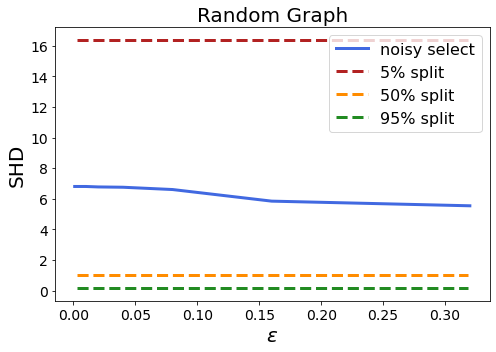

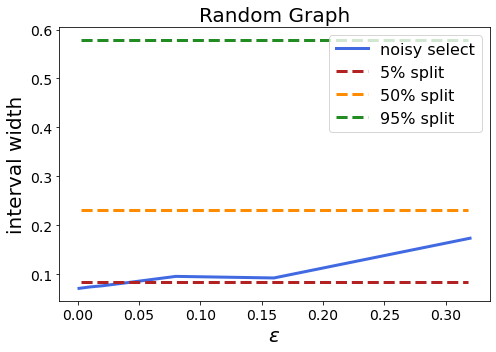

In [5]:
''' Plot the corresponding results. '''

colors=['firebrick', 'darkorange', 'forestgreen']

plt.figure(figsize=(7, 5))
plt.plot(eps_choices, [np.mean(noisy_shd[(eps, delta)]) for eps in eps_choices], \
         color='royalblue', linewidth=3, label="noisy select")
for i, split in enumerate(split_choices):
    plt.axhline(y=np.mean(split_shd[(split, delta)]), linestyle='--', xmin=0.05, xmax=0.95, \
                color=colors[i], linewidth=3, label=str(int(split*100))+'% split')
plt.xlabel("$\epsilon$", fontsize=20)
plt.ylabel("SHD", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16, loc=1)
plt.title("Random Graph", fontsize=20)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 5))
plt.plot(eps_choices, [np.mean(noisy_widths[(eps, delta)]) for eps in eps_choices], \
         color='royalblue', linewidth=3, label="noisy select")
for i, split in enumerate(split_choices):
    plt.axhline(y=np.mean(split_widths[(split, delta)]), linestyle='--', xmin=0.05, xmax=0.95, \
                color=colors[i], linewidth=3, label=str(int(split*100))+'% split')
plt.xlabel("$\epsilon$", fontsize=20)
plt.ylabel("interval width", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16, loc=1)
plt.title("Random Graph", fontsize=20)
plt.tight_layout()
plt.show()

In [6]:
''' [EXTRA] See SHD to *true* graph for full data. '''

full_shd = []

for trial in range(trials):
    np.random.seed(trial)

    G = dag_avg_deg(d, avg_deg, w_min=2, w_max=4)
    p_remove = 2.5/np.sum(G != 0)
    data = sempler.LGANM(G, (0,0), (1,1)).sample(n=n)

    G_options = generate_graphs(G, no_graphs, p_remove, p_add)

    full_scores = [score(data, G_options[j], delta=delta) for j in range(no_graphs)]
    full_G_est = G_options[np.argmin(full_scores)]

    full_shd.append(np.sum(np.abs(G - full_G_est)))
    
print(f"The shd to the *true* graph using the full data for selection is: {np.round(np.mean(full_shd), 2)}")

The shd to the *true* graph using the full data for selection is: 33.83
